## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [258]:
# %pip install imbalanced-learn
# %pip install bayesian-optimization

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import accuracy_score

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [260]:
data = pd.read_csv("pitching.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [261]:
# data.dropna() -> 결측치를 포함하는 행 제거
# data.dropna(axis=1) -> 결측치를 포함하는 열 제거
data = data.dropna(axis=1)

data.columns

Index(['player_id', 'year', 'stint', 'team_id', 'w', 'l', 'g', 'gs', 'cg',
       'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so', 'bk', 'r'],
      dtype='object')

In [262]:
data.head(5)

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

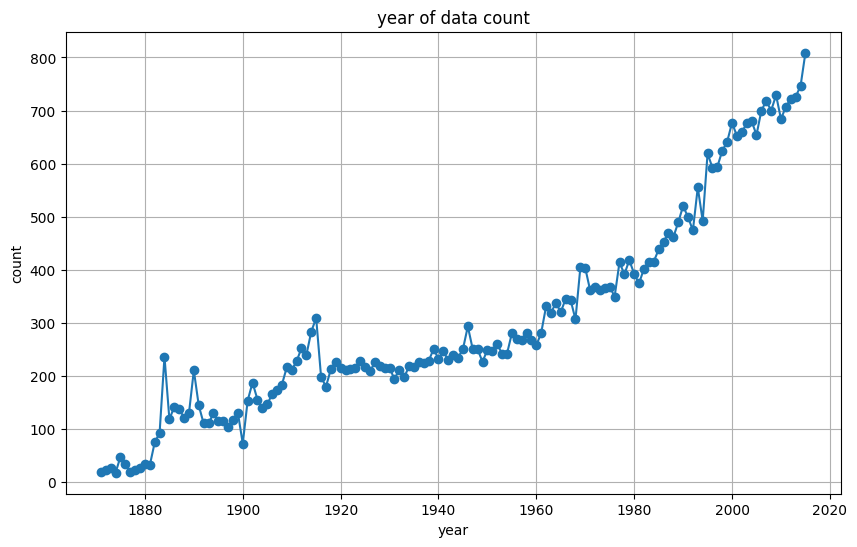

In [263]:
year_count = data.groupby('year').size()

plt.figure(figsize=(10, 6))
plt.plot(year_count.index, year_count.values, marker='o', linestyle='-')
plt.title('year of data count')
plt.xlabel('year')
plt.ylabel('count')
plt.grid(True)
plt.show()


1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [264]:
data = data[data['year'] >= 1980]
len(data)

21157

1.6 reset_index()를 통해 재배열하세요.

In [265]:
# reset_index() -> 데이터프레임의 인덱스 재설정
# drop=True -> 원래의 인덱스를 데이터프레임에서 완전히 제거
data = data.reset_index(drop=True)
data

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [266]:
data['w'].value_counts

<bound method IndexOpsMixin.value_counts of 0         8
1        12
2        14
3         0
4         7
         ..
21152    11
21153     0
21154    13
21155     0
21156     0
Name: w, Length: 21157, dtype: int64>

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [267]:
data = data[data['w'] != 0]
len(data)

15303

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [268]:
data['w'] = np.where(data['w'] >= 10, 1, 0)
data

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [269]:
data['w'].value_counts()

0    12589
1     2714
Name: w, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [270]:
data = data.drop(['player_id', 'year', 'team_id'], axis=1)
data

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [271]:
# 타겟 변수 분리
X = data.drop('w', axis=1)
y = data['w']

# SMOTE 객체 생성
smote = SMOTE(sampling_strategy='auto', random_state=123)

# SMOTE 적용
X_smote, y_smote = smote.fit_resample(X, y)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [272]:
print("smote 적용 전")
print(y.value_counts())

print("---")

print("smote 적용 후")
print(y_smote.value_counts())

smote 적용 전
0    12589
1     2714
Name: w, dtype: int64
---
smote 적용 후
0    12589
1    12589
Name: w, dtype: int64


In [273]:
data_smote = pd.concat([X_smote, y_smote], axis=1)
data_smote

,stint,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r,w
0,1,13,40,21,5,1,2,193,79,13,66,74,1,83,0
1,1,12,31,31,7,2,0,228,98,27,49,78,1,110,1
2,1,11,35,35,7,1,0,227,108,20,74,114,0,120,1
3,1,10,59,0,0,0,22,87,40,7,40,79,1,43,0
4,1,8,35,14,0,0,2,132,53,8,43,75,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,14,34,34,3,0,0,267,131,24,86,139,0,142,1
25174,1,7,32,32,1,0,0,210,88,21,69,105,0,100,1
25175,1,7,29,29,4,1,0,172,68,16,52,129,1,72,1
25176,1,5,71,0,0,0,6,90,35,6,43,97,2,43,1


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

SMOTE의 동작방식  

SMOTE 알고리즘은 오버 샘플링 기법 중 합성 데이터를 생성하는 방식  
낮은 비율로 존재하는 클래스의 데이터를 최근접 이웃 알고리즘 (KNN 알고리즘)을 활용하여  
새롭게 생성하는 방법  

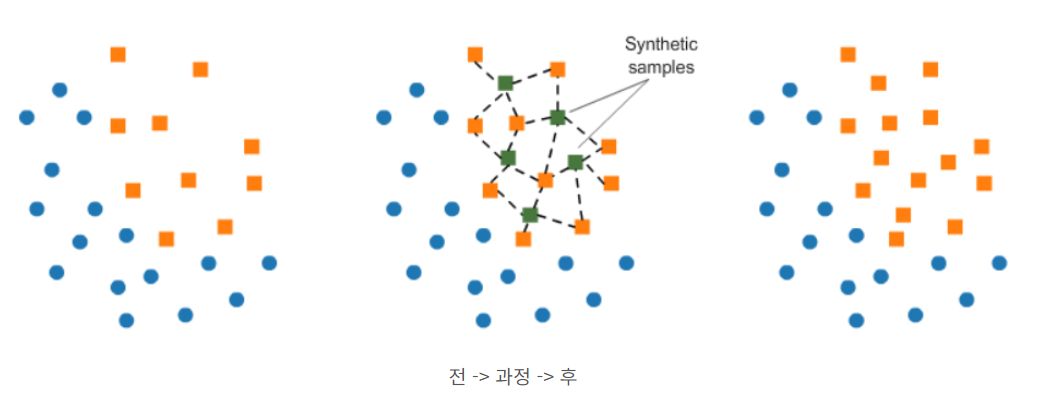

- 장점
  - 무작위로 오버 샘플링을 수행하는 방법보다 과적합 가능성이 적음
  - 언더 샘플링에 비해 정보가 소실되지 않고, 데이터의 수가 줄어들지 않음
- 단점
  - 새로운 데이터 생성시 다른 클래스는 고려하지 않아 생성된 데이터가  
  다른 클래스의 데이터와 중첩되는 경우가 발생하여 노이즈를 생성할 수 있음

[참고] https://chaemi720.tistory.com/336

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

- Resampling  
  - 소수 클래스의 데이터를 그대로 복제하여 데이터 수를 늘리는 방법  

- Borderline-SMOTE  
  - 다수 클래스와 가까운 경계에 존재하는 소수 클래스만 선택하여 SMOTE를 진행하는 기법

- ADASYN    
  - 다수 클래스와의 거리에 따라 오버샘플링 하는 개수를 다르게 하는 기법

[참고] https://yeong-jin-data-blog.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%88%EA%B7%A0%ED%98%95-Oversampling-%EB%B0%A9%EB%B2%95%EB%93%A4

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [274]:
# train:60%
X_train, X_temp, y_train, y_temp = train_test_split(X_smote, y_smote, test_size=0.4, random_state=123)

# temp -> val:20% / test:20%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 15106
Validation set size: 5036
Test set size: 5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

- 하이퍼 파라미터를 조정하는 과정에 있어 과적합을 방지하고 모델의 일반화 능력을 평가하기 위함

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [275]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [276]:
# RandomForestClassifier 
rf_model = RandomForestClassifier()

# RandomizedSearchCV 
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_grid, 
                                   n_iter=100, 
                                   cv=5, 
                                   scoring='accuracy', 
                                   random_state=42
                                   )

# random_search 실행
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Score: {:.4f}".format(random_search.best_score_))

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best Score: 0.9568


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

- n_estimators: 결정 트리의 수
- max_depth: 결정 트리의 최대 깊이
- min_samples_split: 내부 노드를 분할하기 위한 최소 샘플 수
  - 클수록 분할 노드가 줄어들어 트리의 깊이가 얕아지며, 과적합을 방지
- min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수
  - 클수록 모델의 복잡도가 감소하여 과적합을 방지
- bootstrap: 부트스트랩(bootstrap) 샘플링을 사용할지 여부
- criterion: 분할의 품질을 측정하는 기능
  - gini는 지니 불순도, entropy는 정보 이득을 의미

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [277]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [278]:
# RandomForestClassifier 
rf_model = RandomForestClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy'
                           )


# grid_search 실행
grid_search.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_search.best_params_))
print("Best Score: {:.4f}".format(grid_search.best_score_))

Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9573


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

RandomizedSearchCV : 하이퍼파라미터의 각 조합을 무작위로 선택하여 탐색  
장점 : 계산시간, 탐색 공간의 유연성(연속적인 값들로 이루어진 하이퍼파라미터 공간을 탐색할때 유리)  
단점 : 완전성(탐색 공간의 일부만을 탐색하기 때문에 상대적으로 최적의 조합을 찾을 확률 낮음)  

GridSearchCV : 지정된 하이퍼파라미터의 모든 조합을 체계적으로 탐색  
장점 : 완전성, 결과의 일관성(항상 동일한 최적의 하이퍼파라미터 조합을 찾음)  
단점 : 계산시간, 탬색 공간의 제한  

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [279]:
param_grid = {
    'n_estimators': (10, 100),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

In [280]:
from sklearn.model_selection import cross_val_score

# 목적 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf_model = RandomForestClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(max_depth), 
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    
    # 교차 검증을 사용한 모델 평가
    cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return cv_score


# BayesianOptimization 생성
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_grid,
    random_state=42,
)

optimizer.maximize(init_points=2, n_iter=20)

print("Best Parameters: {}".format(optimizer.max['params']))
print("Best Score: {:.4f}".format(optimizer.max['target']))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


| 1         | 0.9435    | 14.36     | 3.852     | 7.856     | 63.88     |
| 2         | 0.9367    | 8.9       | 1.468     | 2.465     | 87.96     |
| 3         | 0.9439    | 14.59     | 3.51      | 7.206     | 65.28     |
| 4         | 0.9509    | 28.41     | 1.207     | 3.545     | 64.71     |
| 5         | 0.9502    | 30.0      | 1.0       | 2.0       | 50.99     |
| 6         | 0.949     | 30.0      | 1.0       | 2.0       | 20.53     |
| 7         | 0.9197    | 5.0       | 1.0       | 2.0       | 10.0      |
| 8         | 0.9415    | 30.0      | 4.0       | 10.0      | 34.55     |
| 9         | 0.9422    | 30.0      | 4.0       | 10.0      | 100.0     |
| 10        | 0.9435    | 30.0      | 4.0       | 2.0       | 79.38     |
| 11        | 0.9387    | 30.0      | 4.0       | 10.0      | 10.0      |
| 12        | 0.9456    | 30.0      | 1.0       | 10.0      | 58.37     |
| 13        | 0.9482    | 13.64     | 1.0       | 2.0       | 44.89     |
| 14        | 0.9498    | 21.38     | 

2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [282]:
print("Random Search")
print("Best Parameters: {}".format(random_search.best_params_))
print("Best Score: {:.4f}".format(random_search.best_score_))
print("---")
print("Grid Search")
print("Best Parameters: {}".format(grid_search.best_params_))
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("---")
print("Bayesian Optimization")
print("Best Parameters: {}".format(optimizer.max['params']))
print("Best Score: {:.4f}".format(optimizer.max['target']))

Random Search
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best Score: 0.9568
---
Grid Search
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9573
---
Bayesian Optimization
Best Parameters: {'max_depth': 28.412990541605318, 'min_samples_leaf': 1.2065872575777807, 'min_samples_split': 3.544830091757907, 'n_estimators': 64.71485839134479}
Best Score: 0.9509


3가지의 하이퍼파라미터 찾은 것중 정확도가 가장 높은 하이퍼파라미터로 학습 진행

In [285]:
# RandomForest
rf_model = RandomForestClassifier(
    n_estimators=200
    , max_depth=30
    , min_samples_split=2
    , min_samples_leaf=1   
    , bootstrap=False
    , criterion='entropy'
    , random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9639


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [ ]:
# %pip install optuna
# %pip install xgboost

하이퍼파라미터의 수치에 영향을 많이 받는 xgboost 모델을 이용

In [297]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [298]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objectiveXGB(trial, x_tr, y_tr, x_val, y_val):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
        , 'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5)
        , 'max_depth': trial.suggest_int('max_depth', 3, 20)

        , 'alpha': trial.suggest_loguniform('alpha', 0.0001, 0.01)
        , 'gamma': trial.suggest_loguniform('gamma', 0.0001, 0.01)

        , 'reg_alpha' : trial.suggest_float('reg_alpha', 0.1, 1)
        , 'reg_lambda' : trial.suggest_float('reg_lambda', 0.01, 0.1)
        
        , 'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1)
        , 'subsample' : trial.suggest_float('subsample', 0.1, 1)
        , 'objective': 'binary:logistic'  # 이진 분류
        , 'tree_method' : "exact"        
        , 'random_state': 0
    }
    
    model = XGBClassifier(**param)
    model.fit(x_tr, y_tr)
    pred = model.predict(x_val)
    score = f1_score(y_val, pred, average="binary")
    
    return score

# 하이퍼 파라미터 튜닝
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(lambda trial: objectiveXGB(trial, X_train, y_train, X_val, y_val), n_trials=1000)

print('Best trial: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-04-09 06:30:48,400] A new study created in memory with name: no-name-75c782a9-f376-43fd-bf15-0330c13b6f31
[I 2024-04-09 06:30:50,823] Trial 0 finished with value: 0.9596180624627013 and parameters: {'n_estimators': 594, 'learning_rate': 0.35901873635434767, 'max_depth': 13, 'alpha': 0.001229607110732572, 'gamma': 0.0007035737028722148, 'reg_alpha': 0.6813047017599905, 'reg_lambda': 0.04938284901364233, 'colsample_bytree': 0.9025957007038717, 'subsample': 0.9672964844509263}. Best is trial 0 with value: 0.9596180624627013.
[I 2024-04-09 06:30:52,204] Trial 1 finished with value: 0.9228295819935692 and parameters: {'n_estimators': 445, 'learning_rate': 0.39690389385091895, 'max_depth': 12, 'alpha': 0.001368009527972693, 'gamma': 0.007098936257405904, 'reg_alpha': 0.16393245237809825, 'reg_lambda': 0.017841636973138664, 'colsample_bytree': 0.11819655769629316, 'subsample': 0.8493578609931441}. Best is trial 0 with value: 0.9596180624627013.
[I 2024-04-09 06:30:54,932] Trial 2 fini

KeyboardInterrupt: 

Optuna를 통해 찾은 하이퍼파라미터로 학습

In [299]:
# XGBoost 
xgb_model = XGBClassifier(
    n_estimators=860
    , learning_rate=0.03462676387314961
    , max_depth=20

    , alpha=0.0002158845905401001
    , gamma=0.00024613840718329025

    , reg_alpha=0.8125299664802909
    , reg_lambda=0.033969279016515246
    
    , colsample_bytree=0.7856558828100426
    , subsample=0.8304739728006699
    , objective='binary:logistic'  # 이진 분류
    , tree_method="exact"        
    , random_state=0
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9579
